In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dask.distributed import Client
from dask_cuda import LocalCUDACluster

import cupy as cp
from ase.build import bulk
from abtem import FrozenPhonons, SMatrix, Potential, GridScan, AnnularDetector

import os
os.environ["MKL_NUM_THREADS"] = "1"

from abtem import config
config.set({'device': 'gpu'})
config.set({'dask.lazy': True})

Runtime: 30. s per frozen phonon on 1 NVidia RTX 2080 Ti

In [2]:
cluster = LocalCUDACluster()
client = Client(cluster)

C:\Users\jacob\anaconda3\envs\dask-gpu\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54540 instead
  warnings.warn(
C:\Users\jacob\anaconda3\envs\dask-gpu\lib\site-packages\dask_cuda\utils.py:214: UserWarning: Cannot get CPU affinity for device with index 0, setting default affinity
  warnings.warn(


In [3]:
atoms = bulk('Si', 'diamond', a=5.43, cubic=True)
atoms *= (20, 20, 1)

In [10]:
frozen_phonons = FrozenPhonons(atoms, 2, {'Si': .0})

potential = Potential(frozen_phonons, 
                      gpts=4096,
                      projection='infinite', 
                      slice_thickness=2)

s_matrix = SMatrix(potential, energy=150e3, planewave_cutoff=20, chunks=4, interpolation=10, store_on_host=True)
scan = GridScan()

detectors = AnnularDetector(50, 150, ensemble_mean=False)

measurement = s_matrix.scan(scan=scan, detectors=detectors, distribute_scan=(5,5), probes_per_reduction=200)

In [11]:
s_matrix.build().array

,Array,Chunk
Bytes,44.25 GiB,512.00 MiB
Shape,"(2, 177, 4096, 4096)","(1, 4, 4096, 4096)"
Count,458 Tasks,90 Chunks
Type,complex64,numpy.ndarray


In [12]:
%%time
measurement.compute()

Wall time: 1min


(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x1e1c50b1a00>)

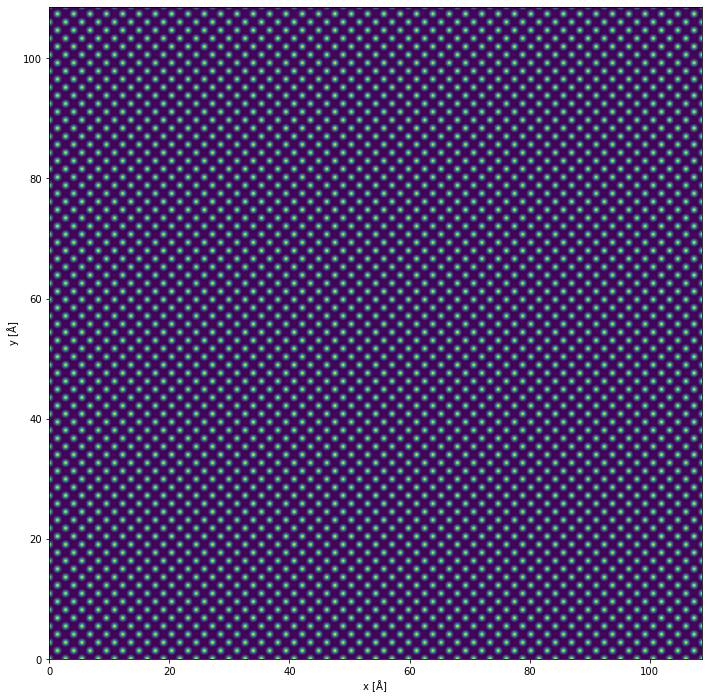

In [13]:
measurement.interpolate(.1).show(figsize=(12,12))